# Predicting Number of Corona Cases In the World

- Predicting the number of corona cases in the upcoming future.
- The dataset for this problem is taken from Kaggle.
(https://www.kaggle.com/imdevskp/corona-virus-report).
- The data of whole world is used to predicted the future cases of Corona.

## 1) Importing the libraries


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

## 2) Importing the dataset


In [246]:
df = pd.read_csv('../corona-virus-report/covid_19_clean_complete.csv',parse_dates=['Date'])
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [247]:
df.drop('Province/State',axis = 1,inplace=True)
df.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [248]:
df.info() #Getting information about different columns datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22794 entries, 0 to 22793
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  22794 non-null  object        
 1   Lat             22794 non-null  float64       
 2   Long            22794 non-null  float64       
 3   Date            22794 non-null  datetime64[ns]
 4   Confirmed       22794 non-null  int64         
 5   Deaths          22794 non-null  int64         
 6   Recovered       22794 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 1.2+ MB


In [249]:
df['Confirmed'].max(), df['Recovered'].max() , df['Deaths'].max()

(699706, 83114, 36773)

## 3) Checking Plot for number of confirmed,recovered and deaths due to corona virus

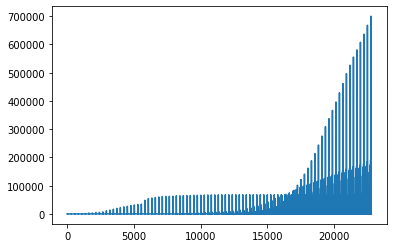

In [250]:
plt.plot(df['Confirmed'])

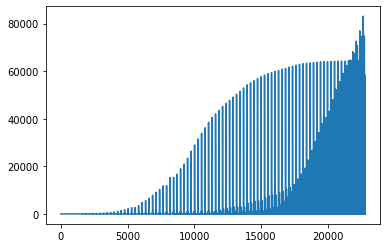

In [251]:
plt.plot(df['Recovered'])

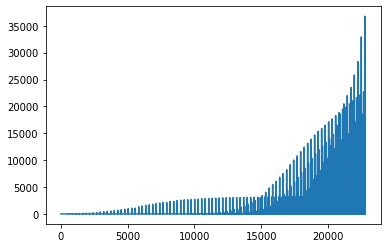

In [255]:
plt.plot(df['Deaths'])

## 4) Preprocessing the Data.

- We will be dealing with the number of confirmed cases of Corona

In [256]:
df.groupby('Date').head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,Angola,-11.2027,17.8739,2020-01-22,0,0,0
...,...,...,...,...,...,...,...
22532,Afghanistan,33.0000,65.0000,2020-04-17,906,30,99
22533,Albania,41.1533,20.1683,2020-04-17,539,26,283
22534,Algeria,28.0339,1.6596,2020-04-17,2418,364,846
22535,Andorra,42.5063,1.5218,2020-04-17,696,35,191


In [257]:
X = df[['Date','Confirmed','Deaths','Recovered']]
X.head()

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,0,0,0
1,2020-01-22,0,0,0
2,2020-01-22,0,0,0
3,2020-01-22,0,0,0
4,2020-01-22,0,0,0


In [261]:
a = X.groupby(['Date']).sum()
print(a)

X = a['Confirmed']
X = X.to_frame()

            Confirmed
Date                 
2020-01-22        555
2020-01-23        654
2020-01-24        941
2020-01-25       1434
2020-01-26       2118
...               ...
2020-04-13    1904835
2020-04-14    1976188
2020-04-15    2056051
2020-04-16    2152643
2020-04-17    2240187

[87 rows x 1 columns]


In [262]:
X.columns

Index(['Confirmed'], dtype='object')

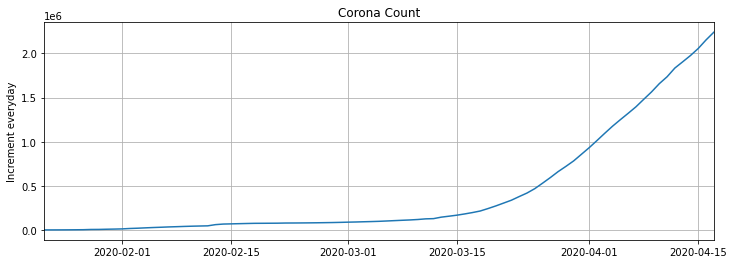

In [263]:
plt.figure(figsize=(12,4))
plt.title('Corona Count')
plt.ylabel('Increment everyday')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X['Confirmed'])
plt.show()

In [264]:
len(X)

87

## 5) Feature Scaling 

In [0]:
window_size = 5
train_set = X[:-window_size].values
test_set = X[-window_size:].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

## 6) Dividing the data into sequences for LSTM

In [266]:
window_size = 5
train_norm = torch.FloatTensor(train_norm).view(-1)
L = len(train_norm)
def input_data(seq,ws):
  out = []
  for i in range(L-ws):
    window = seq[i:i+ws]
    output = seq[i+ws:i+ws+1]
    out.append((window,output))

  return out  

training = input_data(train_norm,window_size)
len(training)

77

## 7) Building a RNN-LSTM model

In [0]:
class TableModel(nn.Module):
  def __init__(self,in_feature=1,hidden_size=40,out_feature=1,dropout=0.5):
    super().__init__()

    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(in_feature,hidden_size)
    self.linear = nn.Linear(hidden_size,out_feature,dropout)
    self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

  def forward(self,seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
    pred = self.linear(lstm_out.view(len(seq),-1))
    return pred[-1]  # we only want the last value

## 8) Initialising the model and declaring loss function and optimizer

In [271]:
model = TableModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

model

TableModel(
  (lstm): LSTM(1, 40)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

## 9) Model training on train dataset

In [272]:
epochs = 1001

for i in range(epochs):
  for seq,y_train in training:    
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

  if i%100 == 0:
    print(f'Epoch : {i} and Loss : {loss.item()}') 



Epoch : 0 and Loss : 1.4964359998703003
Epoch : 100 and Loss : 0.007326036691665649
Epoch : 200 and Loss : 0.002559231361374259
Epoch : 300 and Loss : 0.0002440065291011706
Epoch : 400 and Loss : 0.0007785353227518499
Epoch : 500 and Loss : 0.0009248872520402074
Epoch : 600 and Loss : 0.0008685211068950593
Epoch : 700 and Loss : 0.000820565561298281
Epoch : 800 and Loss : 0.0007728181080892682
Epoch : 900 and Loss : 0.0007245399174280465
Epoch : 1000 and Loss : 0.0006775952642783523


## 10) Testing on the test dataset

In [0]:
future = 5

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])
  with torch.no_grad():

    model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
    preds.append(model(seq).item())



In [274]:
preds[window_size:]

[1.086310625076294,
 1.1913975477218628,
 1.2981668710708618,
 1.4041190147399902,
 1.5111790895462036]

In [275]:
true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_preds

array([[1913871.87751091],
       [2010245.15016109],
       [2108161.32137197],
       [2205328.07221627],
       [2303510.88620967]])

In [276]:
X.tail()

,Confirmed
Date,
2020-04-13,1904835
2020-04-14,1976188
2020-04-15,2056051
2020-04-16,2152643
2020-04-17,2240187


In [0]:
#x = pd.DataFrame(['2020-04-13','2020-04-14','2020-04-15','2020-04-16','2020-04-17'])

rng = pd.date_range('2020-04-13', periods=5)
df = pd.DataFrame({ 'Date': rng})
c = df['Date']

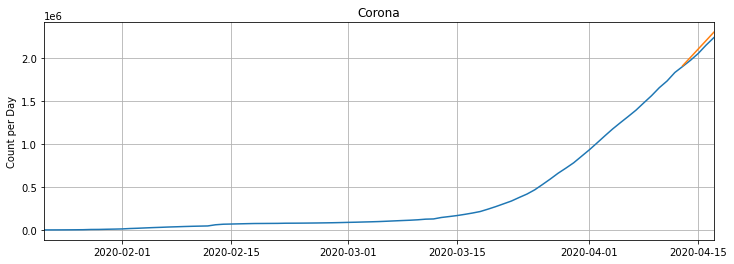

In [279]:
plt.figure(figsize=(12,4))
plt.title('Corona')
plt.ylabel('Count per Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X['Confirmed'])
plt.plot(c,true_preds)
plt.show()

## 11) Predicting the future value


### 11.1) Training on full dataset

In [280]:
epochs = 1000

# set model to back to training mode
model.train()
y = X['Confirmed'].values
# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    if epoch%100 == 0:
      print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00041449
Epoch: 101 Loss: 0.00045223
Epoch: 201 Loss: 0.00016798
Epoch: 301 Loss: 0.00017536
Epoch: 401 Loss: 0.00017855
Epoch: 501 Loss: 0.00017844
Epoch: 601 Loss: 0.00017634
Epoch: 701 Loss: 0.00017261
Epoch: 801 Loss: 0.00016782
Epoch: 901 Loss: 0.00016238

Duration: 144 seconds


### 11.2) Predicting Future Value for next 15 Days

In [281]:
window_size = 5
future = 15
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
true_predictions

array([[1904835.02670908],
       [1976188.01998901],
       [2056051.02472544],
       [2152642.97204447],
       [2240187.        ],
       [2432282.66402435],
       [2556044.06673431],
       [2688616.63991261],
       [2824769.61462307],
       [2958314.9474287 ],
       [3086674.36476803],
       [3192405.07307625],
       [3285200.76153946],
       [3363321.35581398],
       [3426982.84671593],
       [3477418.97165108],
       [3516209.21352196],
       [3546233.27188683],
       [3569094.65829277],
       [3586315.45388031]])

## 12) Showing the future prediction in the form of graph and tabular form

In [0]:
rng = pd.date_range('2020-04-13', periods=20)
df = pd.DataFrame({ 'Date': rng})
c = df['Date']

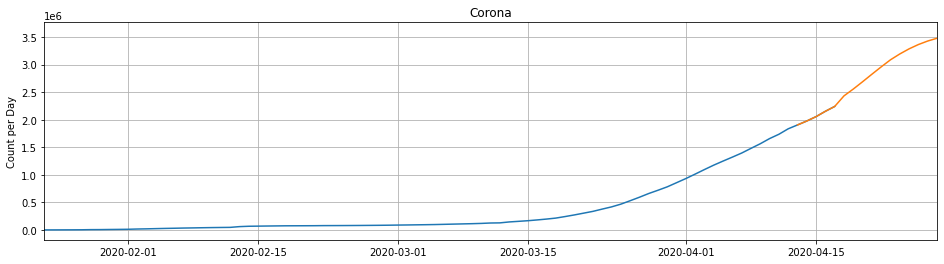

In [283]:
import datetime
plt.figure(figsize=(16,4))
plt.title('Corona')
plt.ylabel('Count per Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X['Confirmed'])
plt.plot(c,true_predictions)
plt.xlim([datetime.date(2020, 1, 23), datetime.date(2020, 4, 28)])
plt.show()

In [296]:
true_pre = pd.DataFrame(true_predictions)
dates = pd.date_range('2020-04-13', periods=20)
x = dates.to_numpy()
print(x)
df = pd.DataFrame(x,columns=['Date'])
df['Prediction'] = true_pre
df

['2020-04-13T00:00:00.000000000' '2020-04-14T00:00:00.000000000'
 '2020-04-15T00:00:00.000000000' '2020-04-16T00:00:00.000000000'
 '2020-04-17T00:00:00.000000000' '2020-04-18T00:00:00.000000000'
 '2020-04-19T00:00:00.000000000' '2020-04-20T00:00:00.000000000'
 '2020-04-21T00:00:00.000000000' '2020-04-22T00:00:00.000000000'
 '2020-04-23T00:00:00.000000000' '2020-04-24T00:00:00.000000000'
 '2020-04-25T00:00:00.000000000' '2020-04-26T00:00:00.000000000'
 '2020-04-27T00:00:00.000000000' '2020-04-28T00:00:00.000000000'
 '2020-04-29T00:00:00.000000000' '2020-04-30T00:00:00.000000000'
 '2020-05-01T00:00:00.000000000' '2020-05-02T00:00:00.000000000']


,Date,Prediction
0,2020-04-13,1.904835e+06
1,2020-04-14,1.976188e+06
2,2020-04-15,2.056051e+06
3,2020-04-16,2.152643e+06
4,2020-04-17,2.240187e+06
5,2020-04-18,2.432283e+06
6,2020-04-19,2.556044e+06
7,2020-04-20,2.688617e+06
8,2020-04-21,2.824770e+06
9,2020-04-22,2.958315e+06


# Thank You!!!